# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [48]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Data Exploration

At the beginning, we take a closer look at the existing data and try to work out differences in the general population and the customer population.

In [3]:
# Show head of general population dataset
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       NaN         NaN      NaN             NaN   
1         ...           4.0       8.0        11.0     10.0             3.0   
2         ...           2.0       9.0         9.0      6.0             3.0   
3         ...           0.0       7.0        10.0     11.0             NaN   
4         ...           2.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             NaN       NaN        3         1                    2  
1             9.0       4.0        5         2                    1  
2             9.0       2.0        5         2                    3  
3             9.0       7.0        3         2                    4  
4             9.0       3.0        4         1                    3  

[5 rows x 366 columns]

In [4]:
# Show description of general population dataset
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV          ...           \
count         628274.000000        798073.000000          ...            
mean              13.700717             8.287263          ...            
std                5.079849            15.628087          ...            
min                0.000000             0.000000          ...            
25%               11.000000             1.000000          ...            
50%               14.000000             4.000000          ...            
75%               17.000000             9.000000          ...            
max               25.000000           595.000000          ...            

                 VHN       VK_DHT4A     VK_DISTANZ        VK_ZG11  \
count  770025.000000  815304.000000  815304.000000  815304.000000   
mean        2.417322       6.001214       7.532130       5.945972   
std         1.166572       2.856091       3.247789       2.771464   
min         0.000000       1.000000       1.000000       1.000000   
25%         2.000000       3.000000       5.000000       4.000000   
50%         2.000000       6.000000       8.000000       6.000000   
75%         3.000000       9.000000      10.000000       8.000000   
max         4.000000      11.000000      13.000000      11.000000   

       W_KEIT_KIND_HH  WOHNDAUER_2008       WOHNLAGE       ZABEOTYP  \
count   783619.000000   817722.000000  798073.000000  891221.000000   
mean         3.933406        7.908791       4.052836       3.362438   
std          1.964701        1.923137       1.949539       1.352704   
min          0.000000        1.000000       0.000000       1.000000   
25%          2.000000        8.000000       3.000000       3.000000   
50%          4.000000        9.000000       3.000000       3.000000   
75%          6.000000        9.000000       5.000000       4.000000   
max          6.000000        9.000000       8.000000       6.000000   

           ANREDE_KZ  ALTERSKATEGORIE_GROB  
count  891221.000000         891221.000000  
mean        1.522098              2.777398  
std         0.499512              1.068775  
min         1.000000              1.000000  
25%         1.000000              2.000000  
50%         2.000000              3.000000  
75%         2.000000              4.000000  
max         2.000000              9.000000  

[8 rows x 360 columns]

In [5]:
# Show info of general population dataset
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
# Show head of customers population dataset
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0         ...               2.0             6.0             9.0       7.0   
1         ...               3.0             0.0             9.0       NaN   
2         ...              11.0             6.0             9.0       2.0   
3         ...               2.0             NaN             9.0       7.0   
4         ...               4.0             2.0             9.0       3.0   

   ZABEOTYP      PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1         3               FOOD    SINGLE_BUYER               0         1   
2         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3         1           COSMETIC     MULTI_BUYER               0         1   
4         1               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

In [7]:
# Show description of customers population dataset
customers.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%       13.000000    14.000000    15.000000    16.000000   
75%       16.000000    16.000000    17.000000    17.000000   
max       18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV          ...           \
count         139810.000000        141725.000000          ...            
mean              10.331579             4.965863          ...            
std                4.134828            14.309694          ...            
min                0.000000             0.000000          ...            
25%                9.000000             1.000000          ...            
50%               10.000000             1.000000          ...            
75%               13.000000             4.000000          ...            
max               25.000000           523.000000          ...            

            VK_DHT4A     VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  \
count  143781.000000  143781.000000  143781.000000   137910.000000   
mean        4.374417       4.564769       3.168868        4.152716   
std         2.924355       2.887035       2.233516        1.974375   
min         1.000000       1.000000       1.000000        0.000000   
25%         2.000000       2.000000       1.000000        2.000000   
50%         4.000000       4.000000       3.000000        5.000000   
75%         7.000000       7.000000       4.000000        6.000000   
max        11.000000      13.000000      11.000000        6.000000   

       WOHNDAUER_2008       WOHNLAGE       ZABEOTYP  ONLINE_PURCHASE  \
count   145056.000000  141725.000000  191652.000000    191652.000000   
mean         8.646371       3.723133       2.576806         0.090247   
std          1.154001       2.095540       1.168486         0.286536   
min          1.000000       0.000000       1.000000         0.000000   
25%          9.000000       2.000000       1.000000         0.000000   
50%          9.000000       3.000000       3.000000         0.000000   
75%          9.000000       5.000000       3.000000         0.000000   
max          9.000000       8.000000       6.000000         1.000000   

           ANREDE_KZ  ALTERSKATEGORIE_GROB  
count  191652.000000         191652.000000  
mean        1.376432              3.060907  
std         0.484492              1.086254  
min         1.000000              1.000000  
25%         1.000000              3.000000  
50%         1.000000              3.000000  
75%         2.000000              4.000000  
max         2.000000              9.000000  

[8 rows x 361 columns]

In [8]:
# Show info of customers population dataset
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


## Data Visualization

The insights gained are now visualized to get an even better understanding of the data set and to find out what are the big difference betwenn the general population and the customer population.

In [9]:
def plot_comparison(feature):
    """
    Plots the value counts of the given feature for the general population and the customers population dataset.
  
    Parameters:
    feature (str): feature which should be plottet, this feature must be a column in the azdias and customers dataset
  
    Returns:
    2x1 suplot of the value counts of the given feature, general population in blue and customers population in orange
  
    """
    # define figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,4))
    # define special xticks for CAMEO_DEUG_2015
    if feature=='CAMEO_DEUG_2015':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['unknown', 'upper class', 'upper middleclass', 'established middleclasse', 'consumption-oriented middleclass', 'active middleclass', 'low-consumption middleclass', 'lower middleclass', 'working class', 'urban working class'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['unknown', 'upper class', 'upper middleclass', 'established middleclasse', 'consumption-oriented middleclass', 'active middleclass', 'low-consumption middleclass', 'lower middleclass', 'working class', 'urban working class'])
    # define special xticks for HH_EINKOMMEN_SCORE
    elif feature == 'HH_EINKOMMEN_SCORE':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3, 4, 5], ['highest income', 'very high income', 'high income', 'average income', 'lower income', 'very low income'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3, 4, 5], ['highest income', 'very high income', 'high income', 'average income', 'lower income', 'very low income'])
    # define special xticks for MOBI_REGIO
    elif feature == 'MOBI_REGIO':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3, 4, 5], ['very high mobility', 'high mobility', 'middle mobility', 'low mobility', 'very low mobility', 'none'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3, 4, 5], ['very high mobility', 'high mobility', 'middle mobility', 'low mobility', 'very low mobility', 'none'])
    # define special xticks for ALTERSKATEGORIE_GROB
    elif feature == 'ALTERSKATEGORIE_GROB':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3, 4], ['< 30 years', '30 - 45 years', '46 - 60 years', '> 60 years', 'uniformly distributed'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3, 4], ['< 30 years', '30 - 45 years', '46 - 60 years', '> 60 years', 'uniformly distributed'])
    # define special xticks for LP_FAMILIE_GROB
    elif feature == 'LP_FAMILIE_GROB':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3, 4, 5], ['none', 'single', 'couple', 'single parent', 'family', 'multiperson household'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3, 4, 5], ['none', 'single', 'couple', 'single parent', 'family', 'multiperson household'])
    # define special xticks for INNENSTADT
    elif feature == 'INNENSTADT':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['none', 'city centre', '3 km away', '3-5 km away', '5-10 km away', '10-20 km away', '20-30 km away', '30-40 km away', '> 40 km away'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['none', 'city centre', '3 km away', '3-5 km away', '5-10 km away', '10-20 km away', '20-30 km away', '30-40 km away', '> 40 km away'])
    # define special xticks for LP_STATUS_GROB
    elif feature == 'LP_STATUS_GROB':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3, 4], ['low-income earners', 'average earners', 'independants', 'houseowners', 'top earners'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3, 4], ['low-income earners', 'average earners', 'independants', 'houseowners', 'top earners'])
    # define special xticks for NATIONALITAET_KZ
    elif feature == 'NATIONALITAET_KZ':
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        plt.sca(axes[0])
        plt.xticks([0, 1, 2, 3], ['unknown', 'sounding german', 'sounding foreign', 'assimilated names'])
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')
        plt.sca(axes[1])
        plt.xticks([0, 1, 2, 3], ['unknown', 'sounding german', 'sounding foreign', 'assimilated names']) 
    # if the feature is nothing of the features used in the elif statement, plot directly over value count numbers
    else:
        azdias[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[0],title='general population', color='tab:blue')
        customers[feature].value_counts().sort_index().plot(kind = 'bar',ax=axes[1],title='customers population',color='tab:orange')

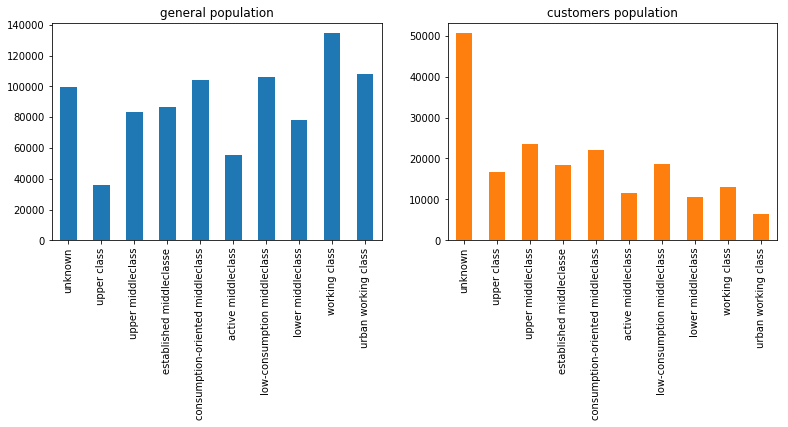

In [10]:
# plot CAMEO_DEUG_2015
azdias['CAMEO_DEUG_2015'] = pd.to_numeric(azdias['CAMEO_DEUG_2015'].replace('X', 0), downcast='integer').fillna(0).astype('int')
customers['CAMEO_DEUG_2015'] = pd.to_numeric(customers['CAMEO_DEUG_2015'].replace('X', 0), downcast='integer').fillna(0).astype('int')
plot_comparison('CAMEO_DEUG_2015')

In [11]:
# Compare percentage of working class to overall dataset without unknown values
perc_work_class_azdias = (azdias['CAMEO_DEUG_2015'].value_counts().loc[8] + azdias['CAMEO_DEUG_2015'].value_counts().loc[9]) / (azdias['CAMEO_DEUG_2015'].count() - azdias['CAMEO_DEUG_2015'].value_counts().loc[0])
print('In the general population are {} % in the working class.'.format(round(perc_work_class_azdias*100)))
perc_work_class_customers = (customers['CAMEO_DEUG_2015'].value_counts().loc[8] + customers['CAMEO_DEUG_2015'].value_counts().loc[9]) / (customers['CAMEO_DEUG_2015'].count() - customers['CAMEO_DEUG_2015'].value_counts().loc[0])
print('In the customer population are only {} % in the working class.'.format(round(perc_work_class_customers*100)))

In the general population are 31.0 % in the working class.
In the customer population are only 14.0 % in the working class.


In [12]:
# Compare percentage of upper class and upper middleclass to overall dataset without unknown values
perc_upper_class_azdias = (azdias['CAMEO_DEUG_2015'].value_counts().loc[1] + azdias['CAMEO_DEUG_2015'].value_counts().loc[2]) / (azdias['CAMEO_DEUG_2015'].count() - azdias['CAMEO_DEUG_2015'].value_counts().loc[0])
print('In the general population are {} % in the upper class and upper middleclass.'.format(round(perc_upper_class_azdias*100)))
perc_upper_class_customers = (customers['CAMEO_DEUG_2015'].value_counts().loc[1] + customers['CAMEO_DEUG_2015'].value_counts().loc[2]) / (customers['CAMEO_DEUG_2015'].count() - customers['CAMEO_DEUG_2015'].value_counts().loc[0])
print('In the customer population are {} % in the upper class and upper middleclass.'.format(round(perc_upper_class_customers*100)))

In the general population are 15.0 % in the upper class and upper middleclass.
In the customer population are 29.0 % in the upper class and upper middleclass.


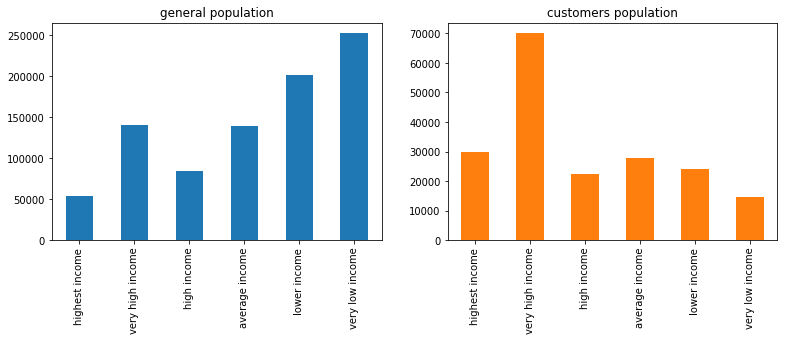

In [13]:
# plot HH_EINKOMMEN_SCORE
plot_comparison('HH_EINKOMMEN_SCORE')

In [14]:
# Compare percentage of high income to overall dataset
perc_high_income_azdias = (azdias['HH_EINKOMMEN_SCORE'].value_counts().loc[1] + azdias['HH_EINKOMMEN_SCORE'].value_counts().loc[2] + azdias['HH_EINKOMMEN_SCORE'].value_counts().loc[3]) / (azdias['HH_EINKOMMEN_SCORE'].count())
print('In the general population are {} % with a high income.'.format(round(perc_high_income_azdias*100)))
perc_high_income_customers = (customers['HH_EINKOMMEN_SCORE'].value_counts().loc[1] + customers['HH_EINKOMMEN_SCORE'].value_counts().loc[2] + customers['HH_EINKOMMEN_SCORE'].value_counts().loc[3]) / (customers['HH_EINKOMMEN_SCORE'].count())
print('In the customers population are {} % with a high income.'.format(round(perc_high_income_customers*100)))

In the general population are 32.0 % with a high income.
In the customers population are 65.0 % with a high income.


In [15]:
# Compare percentage of low income to overall dataset
perc_low_income_azdias = (azdias['HH_EINKOMMEN_SCORE'].value_counts().loc[5] + azdias['HH_EINKOMMEN_SCORE'].value_counts().loc[6]) / (azdias['HH_EINKOMMEN_SCORE'].count())
print('In the general population are {} % with a low income.'.format(round(perc_low_income_azdias*100)))
perc_low_income_customers = (customers['HH_EINKOMMEN_SCORE'].value_counts().loc[5] + customers['HH_EINKOMMEN_SCORE'].value_counts().loc[6]) / (customers['HH_EINKOMMEN_SCORE'].count())
print('In the customers population are {} % with a low income.'.format(round(perc_low_income_customers*100)))

In the general population are 52.0 % with a low income.
In the customers population are 20.0 % with a low income.


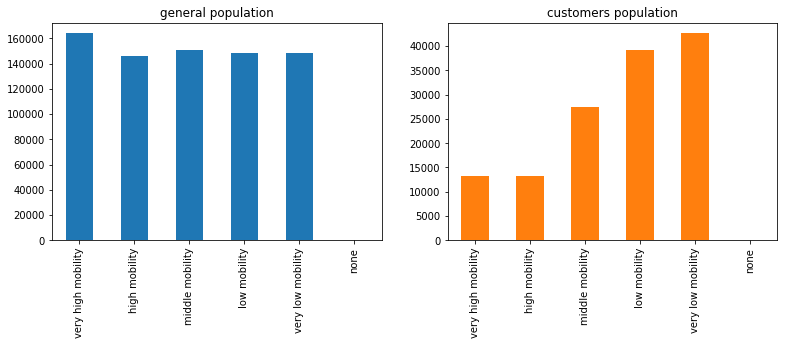

In [16]:
# plot MOBI_REGIO
plot_comparison('MOBI_REGIO')

In [17]:
# Compare percentage of high mobility to overall dataset
perc_high_mobility_azdias = (azdias['MOBI_REGIO'].value_counts().loc[1] + azdias['MOBI_REGIO'].value_counts().loc[2]) / (azdias['MOBI_REGIO'].count())
print('In the general population are {} % with a high mobility.'.format(round(perc_high_mobility_azdias*100)))
perc_high_mobility_customers = (customers['MOBI_REGIO'].value_counts().loc[1] + customers['MOBI_REGIO'].value_counts().loc[2]) / (customers['MOBI_REGIO'].count())
print('In the customers population are {} % with a high mobility.'.format(round(perc_high_mobility_customers*100)))

In the general population are 41.0 % with a high mobility.
In the customers population are 19.0 % with a high mobility.


In [18]:
# Compare percentage of low mobility to overall dataset
perc_low_mobility_azdias = (azdias['MOBI_REGIO'].value_counts().loc[4] + azdias['MOBI_REGIO'].value_counts().loc[5]) / (azdias['MOBI_REGIO'].count())
print('In the general population are {} % with a low mobility.'.format(round(perc_low_mobility_azdias*100)))
perc_low_mobility_customers = (customers['MOBI_REGIO'].value_counts().loc[4] + customers['MOBI_REGIO'].value_counts().loc[5]) / (customers['MOBI_REGIO'].count())
print('In the customers population are {} % with a low mobility.'.format(round(perc_low_mobility_customers*100)))

In the general population are 39.0 % with a low mobility.
In the customers population are 60.0 % with a low mobility.


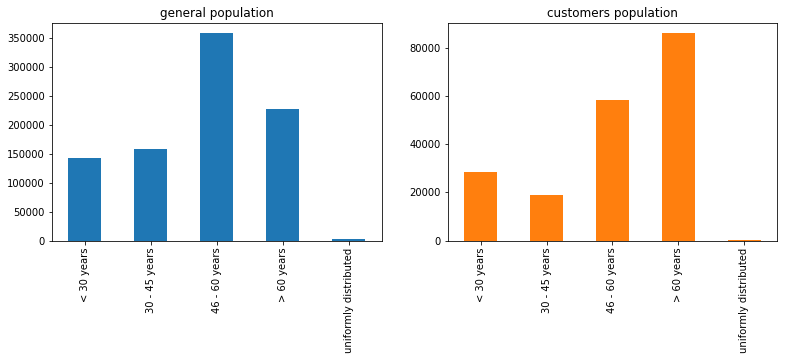

In [19]:
# plot ALTERSKATEGORIE_GROB
plot_comparison('ALTERSKATEGORIE_GROB')

In [20]:
# Compare percentage of people older than 60 years to overall dataset
perc_older_60_azdias = (azdias['ALTERSKATEGORIE_GROB'].value_counts().loc[4]) / (azdias['ALTERSKATEGORIE_GROB'].count())
print('In the general population are {} % older than 60 years.'.format(round(perc_older_60_azdias*100)))
perc_older_60_customers = (customers['ALTERSKATEGORIE_GROB'].value_counts().loc[4]) / (customers['ALTERSKATEGORIE_GROB'].count())
print('In the customer population are only {} % older than 60 years.'.format(round(perc_older_60_customers*100)))

In the general population are 26.0 % older than 60 years.
In the customer population are only 45.0 % older than 60 years.


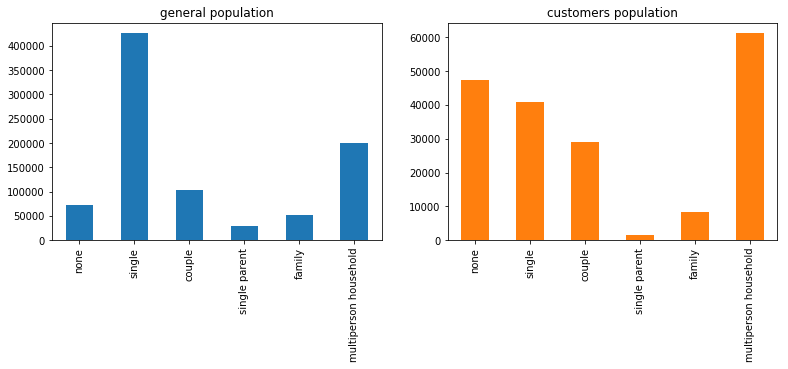

In [21]:
# plot LP_FAMILIE_GROB
plot_comparison('LP_FAMILIE_GROB')

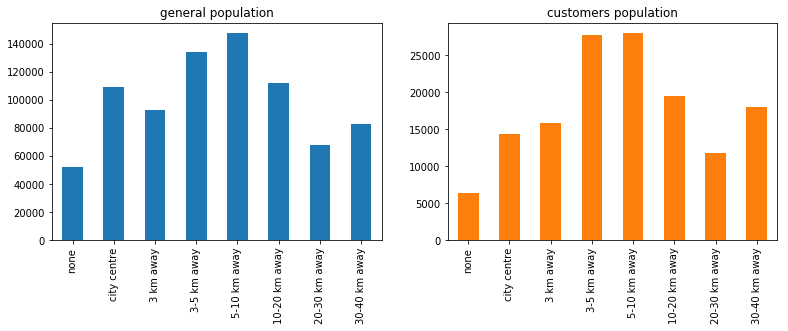

In [22]:
# plot INNENSTADT
plot_comparison('INNENSTADT')

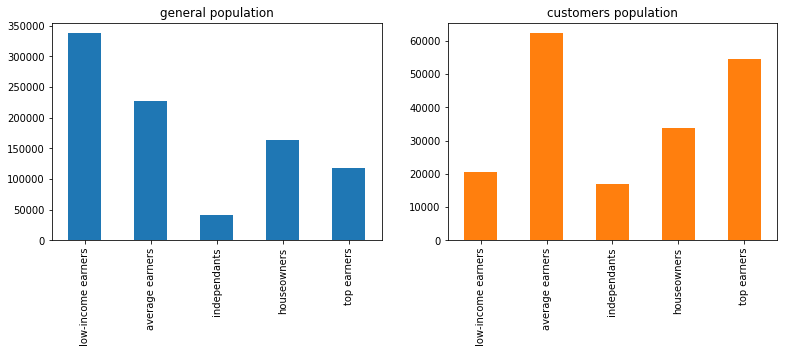

In [23]:
# plot LP_STATUS_GROB
plot_comparison('LP_STATUS_GROB')

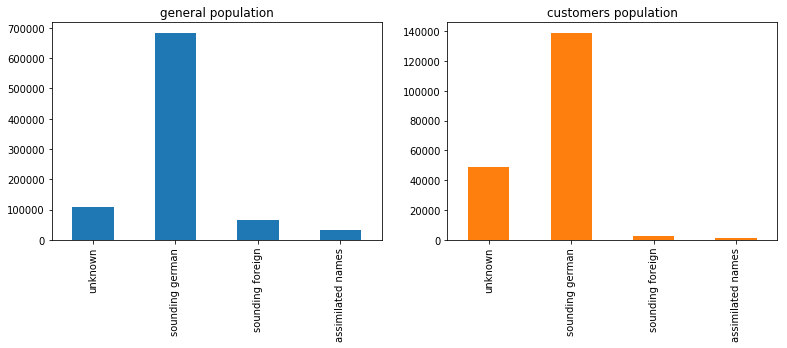

In [24]:
# plot NATIONALITAET_KZ
plot_comparison('NATIONALITAET_KZ')

## Summary

The customers are more upper class (29 %) and high income earners (65 %). They have a low mobility (60 %) and they are pretty old (45 % are older than 60 years). The customers have a high status (lot of independants, houseowners and top earners), only a few are foreigner, they are less single and a lot live in a mulitperson household. The distribution of the distance to city centre are almost the same compared to the general population.

## Data Preprocessing

### Mixed-type data fix

According to the error messages during the data loading, columns (18, 19) in both azdias and customers dataframes exhibit mixed types issue. Therefore, this step will focus on figuring out the problem and fix it.



In [25]:
# Check the (18,19) columns in azdias dataframe
mix_column = list(azdias.iloc[:, 18:20].columns)
print("{} columns have mixed-type data issue in both azdias and customers dataframes.\n".format(mix_column))
print("The values in CAMEO_DEUG_2015 are {}\n".format(list(azdias[mix_column[0]].unique())))
print("The values in CAMEO_INTL_2015 are {}".format(list(azdias[mix_column[1]].unique())))

['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] columns have mixed-type data issue in both azdias and customers dataframes.

The values in CAMEO_DEUG_2015 are [0, 8, 4, 2, 6, 1, 9, 5, 7, 3]

The values in CAMEO_INTL_2015 are [nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0, '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX']


The "CAMEO_DEUG_2015", "CAMEO_INTL_2015" are the columns with mixed-type data issue in two dataframes, they are caused by the appearance of "X"/"XX" and the decimal point (1 vs. 1.0) issue.

In [26]:
# Replace the "X"/"XX" by -1 in CAMEO_DEUG_2015 column and convert the data to consistent type (float) to solve mixd type issue
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'][azdias['CAMEO_DEUG_2015'].notnull()].replace("X","-1").astype('int')
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'][azdias['CAMEO_INTL_2015'].notnull()].replace("XX","-1").astype('int')

In [27]:
# Examine whether mixed type issue solved or not in azdias dataframe
azdias['CAMEO_DEUG_2015'].value_counts()

8    134441
9    108177
6    105874
4    103912
0     99352
3     86779
2     83231
7     77933
5     55310
1     36212
Name: CAMEO_DEUG_2015, dtype: int64

In [28]:
# Examine whether mixed type issue solved or not in azdias dataframe
azdias['CAMEO_INTL_2015'].value_counts()

 51.0    133694
 41.0     92336
 24.0     91158
 14.0     62884
 43.0     56672
 54.0     45391
 25.0     39628
 22.0     33155
 23.0     26750
 13.0     26336
 45.0     26132
 55.0     23955
 52.0     20542
 31.0     19024
 34.0     18524
 15.0     16974
 44.0     14820
 12.0     13249
 35.0     10356
 32.0     10354
 33.0      9935
-1.0        373
Name: CAMEO_INTL_2015, dtype: int64

In [29]:
# Check if other columns have same mixed-type issue
azdias.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
       'OST_WEST_KZ'],
      dtype='object')

'CAMEO_DEU_2015 also contain 'XX' value, same procedure will apply to it. 'OST_WEST_KZ' is categorical variable, will be on hot encoded later. 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM' are categorical variables with a lot of distinct attributes, are dropped later. 

In [30]:
# Replace the 'XX' with NaN in azdias dataframe
azdias.CAMEO_DEU_2015 = azdias.CAMEO_DEU_2015.replace('XX', np.NaN)

In [31]:
# Load feature_summary dataframe
feature = pd.read_csv('./feature_summary.csv')
feature.drop(['Unnamed: 0'],axis=1, inplace=True)
feature.head()

attribute         type missing_or_unknown
0              AGER_TYP  categorical              -1, 0
1  ALTERSKATEGORIE_GROB      ordinal           -1, 0, 9
2             ANREDE_KZ  categorical              -1, 0
3         CJT_GESAMTTYP  categorical                  0
4     FINANZ_MINIMALIST      ordinal                 -1

In [32]:
# Split the value in missing_or_unknown column, convert them into numeric variable
feature_notnull = feature[feature['missing_or_unknown'].notna()]
feature_notnull['missing_or_unknown'] = feature_notnull['missing_or_unknown'].apply(lambda x: x.split(','))

# Re-encode the unknown value in each attribute as NaN based the information from feature_summary dataframe

# Iterate through each attribute in feature
for i in feature_notnull.index:
    # Convert each value in missing_or_unknown to 'int' variable if there is
    for value in range(len(feature_notnull.loc[i,'missing_or_unknown'])):
        feature_notnull.loc[i,'missing_or_unknown'][value] = int(feature_notnull.loc[i,'missing_or_unknown'][value])

    # Replace the unknown or missing value to NaN in azdias in the reference of feature dataframe
    azdias.loc[:,(feature_notnull.loc[i, 'attribute'])].replace(feature_notnull.loc[i,'missing_or_unknown'], np.nan, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Drop columns with a lot of NaN Values in azdias dataframe

(array([ 109.,  226.,   10.,    1.,    1.,    2.,    3.,    3.,    2.,    9.]),
 array([      0. ,   89001.6,  178003.2,  267004.8,  356006.4,  445008. ,
         534009.6,  623011.2,  712012.8,  801014.4,  890016. ]),
 <a list of 10 Patch objects>)

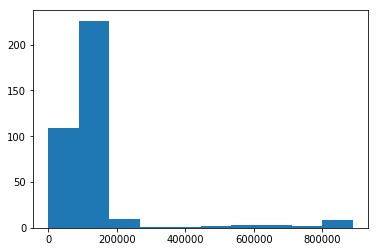

In [33]:
# Find columns with a lot of NaNs and show them in histogram
nan_distr = azdias.isna().sum().sort_values(ascending=False)
plt.hist(nan_distr)

There are some outlier columns which have more than 200000 NaN values, which will be deleted in the next step.

In [34]:
# Find all columns with more than 200000 NaNs and save them in a list
drop_columns = list(azdias.isna().sum()[azdias.isna().sum()>200000].index)
print(drop_columns)
print(len(drop_columns))

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
31


In [35]:
# Function to extract columns with nan
def extract_columns_with_nan(df):
    """
    Calculate the percentage of NaN values in each column and give them as new dataframe back
  
    Parameters:
    df (pandas dataframe): dataframe which contains columns with nan values
  
    Returns:
    df_nan (pandas dataframe): contains all column names with nan values in it and the percentage of nan values in each column, sorted by percentage descending
  
    """
    # Extract columns with NaNs
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]
    # Calculate percentage of NaN for each column
    dic_nan = {'sum': columns_with_nans.values, 'percent': np.round(columns_with_nans.values * 100 / df.shape[0], 2)}
    # Build a dataframe including only columns with NaNs
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)
    # Sort by percentage
    df_nan.sort_values(by='percent', ascending=False, inplace=True)
    return df_nan

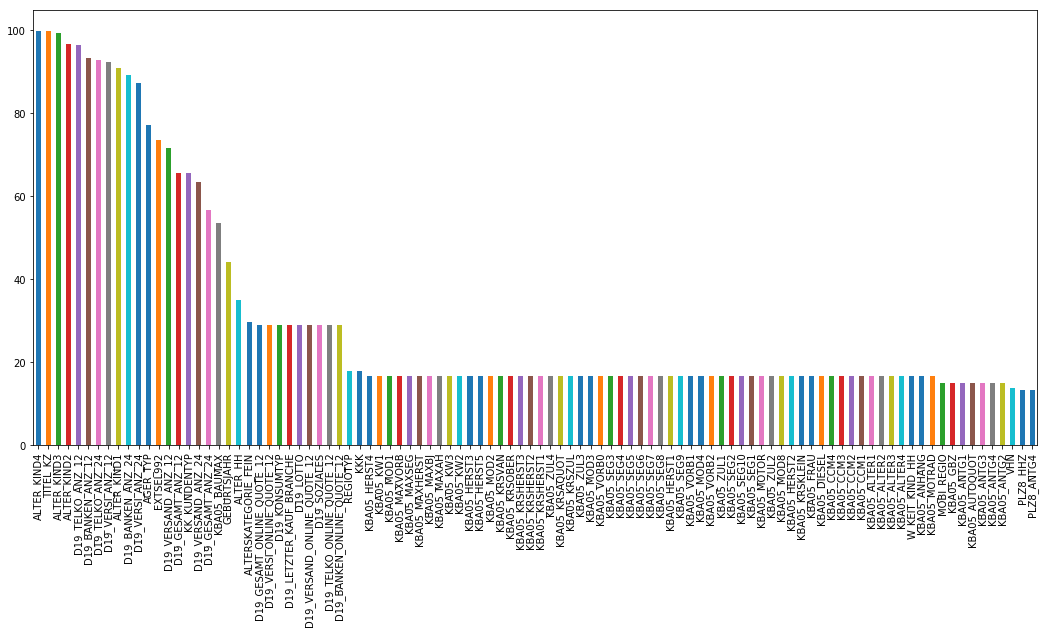

In [36]:
# calculate percentage of nan values in each column
azdias_nan = extract_columns_with_nan(azdias) 
# plot the 100 columns with the highest nan percentage
azdias_nan.percent[0:100].plot.bar(figsize=(18, 8));

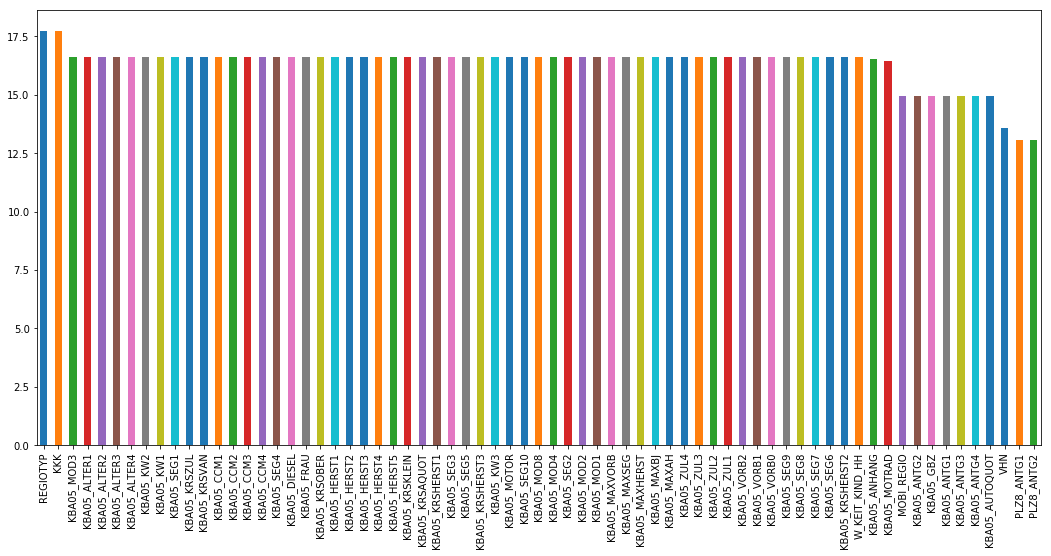

In [37]:
# drop columns with more than 200000 nan values
azdias.drop(drop_columns, axis='columns', inplace=True)

azdias_nan = extract_columns_with_nan(azdias)
# percentage plot without the droped nan columns (only the 100 highest percentage columns before dropping are considered)
azdias_nan.percent[0:100-len(drop_columns)].plot.bar(figsize=(18, 8));

### Drop rows with a lot of NaN Values¶

(array([  7.36923000e+05,   3.65000000e+02,   4.66740000e+04,
          1.45600000e+03,   6.36000000e+02,   5.18600000e+03,
          9.00000000e+00,   6.62100000e+03,   1.81980000e+04,
          7.51530000e+04]),
 array([   0. ,   24.6,   49.2,   73.8,   98.4,  123. ,  147.6,  172.2,
         196.8,  221.4,  246. ]),
 <a list of 10 Patch objects>)

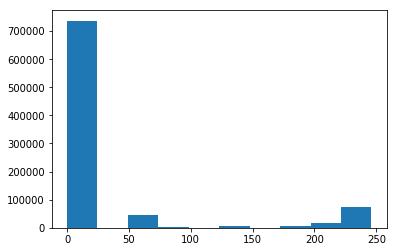

In [38]:
# How much data is missing in each row of the dataset?
rows_nan = azdias.isna().sum(axis=1).sort_values(ascending=False)
#print(rows_nan)
plt.hist(rows_nan)

The histogram shows, that there are some outliers, where a lot of nan values are in the row but the main rows are nearly completed filled with values. In the next step we will delete the rows with more than 25 NaN values.

In [39]:
# Rows with more than 25 NaN values
drop_rows = list(azdias.isna().sum(axis=1)[azdias.isna().sum(axis=1)>25].index)
#print(drop_rows)

In [40]:
# drop rows with more than 25 NaN values
azdias = azdias.drop(drop_rows)

### Drop highly correlated features

In [41]:
# Create positive correlation matrix
corr_df = azdias.corr().abs()

# Creat and apply mask
mask = np.triu(np.ones_like(corr_df,dtype=bool))
tri_df = corr_df.mask(mask)

In [42]:
# Find the columns that meet treshold
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.7)]
len(to_drop)

88

In [43]:
print(to_drop)

['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'CAMEO_DEUG_2015', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'D19_BANKEN_DATUM', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_VERSAND_DATUM', 'EINGEZOGENAM_HH_JAHR', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FIRMENDICHTE', 'GEMEINDETYP', 'KBA05_ANTG1', 'KBA05_AUTOQUOT', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_MOD8', 'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_ANZAHL_PKW', 'KBA13_BAUMAX', 'KBA13_BJ_1999', 'KBA13_BJ_2004', 'KBA13_BMW', 'KBA13_FAB_SONSTIGE', 'KBA13_GBZ', 'KBA13_HALTER_30', 'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_FORD_OPEL', 'KBA13_HHZ', 'KBA1

In [44]:
# Print out the the correlation (Pearson’s R)
tri_df.unstack().sort_values(ascending=False)[:14]

KBA13_FAB_SONSTIGE   KBA13_HERST_SONST             1.000000
LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB           0.990187
LP_FAMILIE_FEIN      LP_FAMILIE_GROB               0.988438
LP_STATUS_FEIN       LP_STATUS_GROB                0.985834
ANZ_HAUSHALTE_AKTIV  ANZ_STATISTISCHE_HAUSHALTE    0.981809
KBA13_GBZ            PLZ8_GBZ                      0.980339
LP_FAMILIE_GROB      LP_LEBENSPHASE_GROB           0.971231
KBA13_HHZ            PLZ8_HHZ                      0.969418
KBA13_KMH_211        KBA13_KMH_250                 0.960268
LP_FAMILIE_FEIN      LP_LEBENSPHASE_GROB           0.959978
CAMEO_DEUG_2015      CAMEO_INTL_2015               0.955288
D19_VERSAND_DATUM    D19_VERSAND_ONLINE_DATUM      0.954553
LP_FAMILIE_GROB      LP_LEBENSPHASE_FEIN           0.953918
KBA13_BAUMAX         PLZ8_BAUMAX                   0.950241
dtype: float64

In [45]:
azdias = azdias.drop(to_drop, axis=1)

### One-hot encoding categorical features

In [ ]:
# Identify binary and multilevel categorical variables
cat_col = feature[feature['type']=='categorical']['attribute']
cat_col = [x for x in cat_col if x in azdias.columns]
binary = []
multilevel = []

for col in cat_col:
    if azdias[col].nunique() == 2:
        binary.append(col)
    if (azdias[col].nunique() > 2) & (azdias[col].nunique() < 30):
        multilevel.append(col)

In [ ]:
print(multilevel)

In [ ]:
print(binary)

In [ ]:
# manually encoding of binary variables
# check if one value is NaN in the column 0
azdias[binary[0]].isnull().sum()
# no NaN included -> no impute necessary
# manualle encoding by substractin 1, to get values 1 and 2 to 0 and 1
azdias[binary[0]] = azdias[binary[0]]-1

In [ ]:
# check if one value is NaN in the column 1
azdias[binary[1]].isnull().sum()
# no NaN included -> no impute necessary
#print(azdias[binary[1]])
# it is already in the right shape (0s and 1s), nothing to do

In [ ]:
# check if one value is NaN in the column 2
azdias[binary[2]].isnull().sum()
# no NaN included -> no impute necessary
# values are float values, typecast to integer necessary
azdias[binary[2]] = azdias[binary[2]].astype(int)
#print(azdias[binary[2]])

In [ ]:
# check if one value is NaN in the column 3
azdias[binary[3]].isnull().sum()
# 36680 NaN values included -> impute necessary
azdias[binary[3]].value_counts()[2.0]
# 2.0 occurs 370193 times in this variable
azdias[binary[3]].value_counts()[1.0]
# 1.0 occurs 332936 times in this variable
# fill NaN values with most_frequent value -> 2.0
azdias[binary[3]]=azdias[binary[3]].fillna(2.0)
# typecast to integer
azdias[binary[3]] = azdias[binary[3]].astype(int)
# substraction of 1 to be in the range of 0 and 1 (instead of 1 and 2)
azdias[binary[3]] = azdias[binary[3]]-1
#print(azdias[binary[3]])

In [ ]:
# check if one value is NaN in the column 4
azdias[binary[4]].isnull().sum()
# no NaN included -> no impute necessary
# replace W with 1 and O with 0
azdias[binary[4]] = azdias[binary[4]].replace('W', 1)
azdias[binary[4]] = azdias[binary[4]].replace('O', 0)
#print(azdias[binary[4]])

In [ ]:
# Get dummie for multilevel feature, keep binary untouch
for feature in multilevel:
    #Get dummie for azdias
    azdias_notnull = azdias[feature][azdias[feature].notnull()]
    dummie_azdias = pd.get_dummies(azdias_notnull,prefix=feature)
    azdias.drop(feature, axis=1, inplace=True)
    azdias = pd.concat([azdias, dummie_azdias], axis = 1)

In [ ]:
# drop other mixed features
azdias = azdias.drop({'LP_LEBENSPHASE_GROB'}, axis=1)
azdias = azdias.drop({'PLZ8_BAUMAX'}, axis=1)
azdias = azdias.drop({'WOHNLAGE'}, axis=1)
azdias_clean.drop(['CAMEO_INTL_2015_LIFE_STAGE'], axis=1, inplace=True)
azdias_clean.drop(['CAMEO_INTL_2015_WEALTH'], axis=1, inplace=True)
azdias_clean.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
azdias_clean.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

In [25]:
def clean_data(df, drop_rows=True):
    # create copy of df
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    #df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)

    # This part converts types of columns 18 and 19 of azias and coustomers df 
    # from float to int and from string to NAN
    col_names = df.iloc[:,18:20].columns
    df[col_names] = df[col_names].replace({'X': -1, 'XX': -1})    
    #df_copy[col_names[0]] = pd.to_numeric(df_copy[col_names[0]], downcast="float")
    #df_copy[col_names[1]] = pd.to_numeric(df_copy[col_names[1]], downcast="float")
    df[col_names] = df[col_names].fillna(-1)
    df[col_names] = df[col_names].astype(int)
    df[['OST_WEST_KZ', 'CAMEO_DEU_2015']] = df[['OST_WEST_KZ', 'CAMEO_DEU_2015']].fillna(-1)
    #df_copy[['OST_WEST_KZ', 'CAMEO_DEU_2015']] df df_copy[['OST_WEST_KZ', 'CAMEO_DEU_2015']].astype(int)
    df[['OST_WEST_KZ', 'CAMEO_DEU_2015']] = df[['OST_WEST_KZ', 'CAMEO_DEU_2015']].fillna(-1)

    print("df columns 18 and 19 converted to float")
    print("shape is: ", df.shape)
    # Find all columns with more than 200000 NaNs and save them in a list
    drop_col = list(df.isna().sum()[df.isna().sum()>200000].index)
    # drop columns with more than 200000 nan values
    df.drop(drop_col, axis='columns', inplace=True)
    print("df columns with more than 200000 missing values dropped")
    print("dropped columns are: ", drop_col)
    print("shape is: ", df.shape)
    #drop rows with more than 25 missing 
    if(drop_rows):
        df = df.dropna(thresh=df.shape[1]-25)
    print("df rows with 25 missing values dropped")
    print("shape is: ", df.shape)
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.7
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    # drop columns with high correlation 
    df = df.drop(to_drop, axis=1)
    print("columns with correlation more than 0.7 are dropped")
    
    # this is just for the costumer df 
    list_cost_col = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
    for col in list_cost_col:
        if col in df.columns:
            df = df.drop([col], inplace=False, axis=1)
        print("this columns from customer df are dropped: ", ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])
        print("shape is: ", df.shape)
    
    #fill object with dummies
    df = pd.get_dummies(df)

    columns_df = list(df.columns.values)

    #imputing the nan value with mode
    print('Imputing nan values with mode')
    mode_imputer = Imputer(missing_values=np.nan,strategy='most_frequent')
    #mode_imputer = mode_imputer.fit(data_df)
    df = mode_imputer.fit_transform(df)
    df = pd.DataFrame(df)
    print('shape after imputing the values', df.shape)

    #converting all values in df to int
    df = df.astype(int)
    
    # normalize df
    normalize = StandardScaler(copy=False).fit_transform(df)
    df = pd.DataFrame(normalize,columns= columns_df)
    print('Shape after normalising' , df.shape)
        
    df = df.set_index('LNR')

    return df

In [9]:
azdias_cleaned = clean_data(azdias)
customers_cleaned = clean_data(customers)

df columns 18 and 19 converted to float
shape is:  (891221, 364)
df columns with more than 200000 missing values dropped
dropped columns are:  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
shape is:  (891221, 349)
df rows with 25 missing values dropped
shape is:  (751275, 349)
columns with correlation more than 0.7 are dropped
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (751275, 234)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (751275, 234)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (751275, 234)
Imputing nan values with mode
shape 

In [10]:
# Save the clean dataframe as pickle files
azdias_cleaned.to_pickle('./azdias_clean.pkl')
customers_cleaned.to_pickle('./customers_clean.pkl')

## Dimensionality reduction

In [67]:
# load cleaned dataframe
azdias_clean = pd.read_pickle('./azdias_clean.pkl')
customers_clean = pd.read_pickle('./customers_clean.pkl')

In [68]:
azdias_columns = list(azdias_clean)
azdias_clean.shape

(751275, 279)

In [69]:
customers_columns = list(customers_clean)
customers_clean.shape

(133627, 310)

In [71]:
# drop all columns which are only in azdias and not in customers dataset from azdias
diff1 = []
for element in azdias_columns:
    if element not in customers_columns:
        diff1.append(element)
azdias_clean.drop(diff1, axis=1, inplace=True)

In [72]:
# drop all columns which are only in customers and not in azdias dataset from customers
diff2 = []
for element in customers_columns:
    if element not in azdias_columns:
        diff2.append(element)
customers_clean.drop(diff2, axis=1, inplace=True)

In [75]:
print(azdias_clean.shape)
print(customers_clean.shape)
print('Any NaNs in azdias?', azdias_clean.isnull().values.any())

(751275, 276)
(133627, 276)
Any NaNs in azdias? False


In [76]:
# use cleaned data for next steps
azdias = azdias_clean

### Principal Component Analysis

In [77]:
from sklearn.decomposition import PCA
pca = PCA() 
pca_df = pca.fit(azdias)

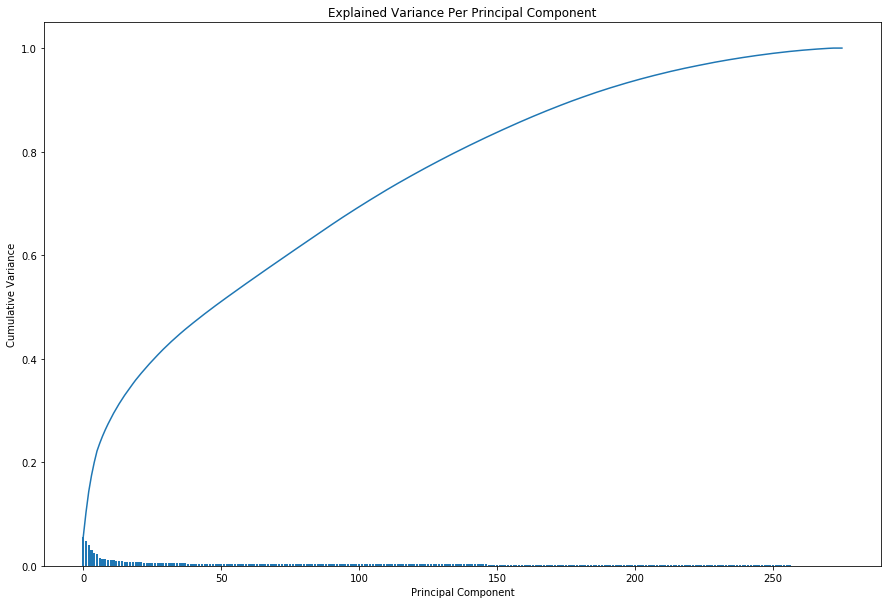

In [78]:
# graph for pca
plt.figure(figsize=(15,10))
plt.plot(np.cumsum(pca_df.explained_variance_ratio_))
plt.bar(range(0,len(pca_df.explained_variance_ratio_)), pca_df.explained_variance_ratio_)

plt.xlabel('Principal Component')
plt.title("Explained Variance Per Principal Component")
plt.ylabel('Cumulative Variance')
plt.show()

The plots above show that the explained variance plateaus a couple of times. The first and sharpest drop-off is around 15 components. At 15 components around 32 % of the total variance is explained. After this we can observe two other, but not as steep drop-offs around 100 and 200 components. At 100 components 66 % of the total variance is explained and at 200 87 %.

With each consecutive component less and less variance is explained which means that after a while the amount of additional explained variance probably is not worth the extra number of components.

With that said 100 components could be considered a good middle point

In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.
# out of the scree_plot we can see that we need approximatelly 25 components to reach a cumulative varaince explained of 85%.
pca = PCA(n_components=100) 
azdias_pca = pca.fit_transform(azdias)

In [80]:
def print_component(pca, comp):
    if comp <= len(pca.components_):
        weight_df = pd.DataFrame({'weight': pca.components_[comp]}, index=azdias.columns)
        print("Most wieghted features for the component ", comp)
        print(weight_df.sort_values(by=['weight']).head(5))
        print(weight_df.sort_values(by=['weight']).tail(5))
    else:
        print('That is not the right input, please read the docstring before continuing.')
        
#Plot the first component
print_component(pca, 1)

Most wieghted features for the component  1
                           weight
KBA13_KMH_180           -0.057171
KBA05_ANTG3             -0.056201
HH_EINKOMMEN_SCORE      -0.054018
ARBEIT                  -0.050536
KBA13_SEG_KOMPAKTKLASSE -0.050296
                 weight
KBA05_MAXSEG   0.196791
KBA05_DIESEL   0.202704
KBA05_MOTRAD   0.208322
KBA05_ANHANG   0.211360
KBA05_KRSOBER  0.223660


In [81]:
# Print the second component
print_component(pca, 2)

Most wieghted features for the component  2
                               weight
KBA13_SEG_OBEREMITTELKLASSE -0.192442
KBA13_BMW                   -0.185609
KBA13_SITZE_4               -0.182478
KBA13_SEG_SPORTWAGEN        -0.169902
KBA13_SEG_OBERKLASSE        -0.150997
                           weight
KBA13_ALTERHALTER_60     0.133523
KBA13_SEG_KOMPAKTKLASSE  0.135319
OST_WEST_KZ_O            0.141275
KBA13_HALTER_20          0.143699
KBA13_KMH_140_210        0.162351


In [82]:
# Print the third component
print_component(pca, 3)

Most wieghted features for the component  3
                     weight
CJT_TYP_6         -0.239836
CJT_KATALOGNUTZER -0.202504
SEMIO_LUST        -0.173222
RETOURTYP_BK_S    -0.163170
AGER_TYP          -0.162013
                  weight
SEMIO_RAT       0.211843
FINANZ_ANLEGER  0.214405
SEMIO_TRADV     0.216694
SEMIO_PFLICHT   0.225798
CJT_TYP_1       0.257949


### Clustering

In [12]:
from sklearn.cluster import KMeans

scores = []
cluster_values = list(range(1,30))
print (cluster_values)
for cv in cluster_values:
    print(cv)
    kmeans = KMeans(n_clusters=cv)
    kmeans.fit(azdias_pca)
    print(kmeans.inertia_)
    scores.append(kmeans.inertia_)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
1
143122754.938
2
135045966.703
3
125486807.613
4
121414998.51
5
118409403.633
6
116009536.062
7
114385821.775
8
113088482.018
9
111953456.074
10
111035580.339
11
110041447.53
12
109586759.924
13
108784013.66
14
108081994.765
15
107540600.417
16
107048527.223
17
106528418.409
18
105756561.289
19
105224298.114
20
104900560.748
21
104370712.55
22
104461069.212
23
103806053.307
24
103234595.486
25
103120107.269
26
102544689.246
27
102292931.37
28
101697215.789
29
101512421.571


Text(0,0.5,'cluster distance')

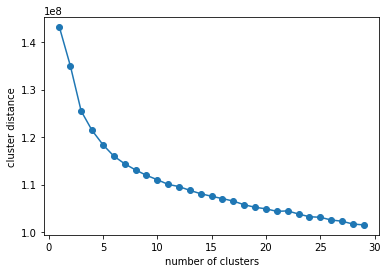

In [14]:
# Plot for elbow method
plt.plot(cluster_values, scores, marker = "o")
plt.xlabel('number of clusters')
plt.ylabel('cluster distance')

In [83]:
kmeans_final = KMeans(11)
model_final = kmeans_final.fit(azdias_pca)
predicted_data_general = model_final.predict(azdias_pca)

In [84]:
#apply all to customers data
# Dimensionality Reduction
finalized_dataset_customer = pca.transform(customers_clean)

# clustering
predicted_data_customer = model_final.predict(finalized_dataset_customer)

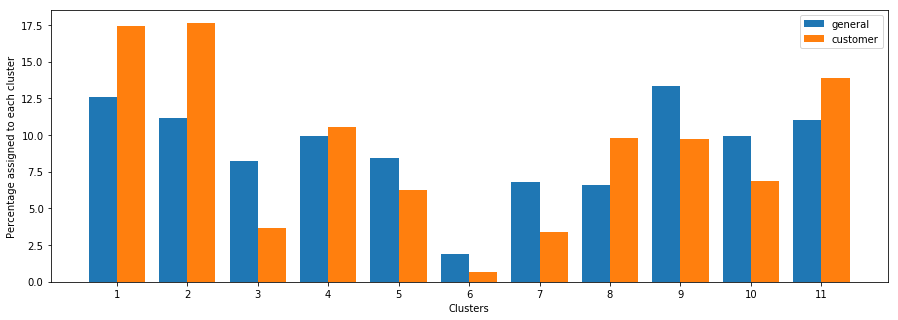

In [93]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
X=[]
Y_gen = []
Y_cust = []
for i in range(11):
    nr_cl_gen = np.sum(predicted_data_general==i)/len(predicted_data_general)*100
    nr_cl_cust = np.sum(predicted_data_customer==i)/len(predicted_data_customer)*100
    X.append(str(i+1))
    Y_gen.append(nr_cl_gen)
    Y_cust.append(nr_cl_cust)
    
#nr_cl1_gen = np.sum(predicted_data_general==0)/len(predicted_data_general)*100
#nr_cl2_gen = np.sum(predicted_data_general==1)/len(predicted_data_general)*100
#nr_cl3_gen = np.sum(predicted_data_general==2)/len(predicted_data_general)*100
#nr_cl4_gen = np.sum(predicted_data_general==3)/len(predicted_data_general)*100
#nr_cl1_cust = np.sum(predicted_data_customer==0)/len(predicted_data_customer)*100
#nr_cl2_cust = np.sum(predicted_data_customer==1)/len(predicted_data_customer)*100
#nr_cl3_cust = np.sum(predicted_data_customer==2)/len(predicted_data_customer)*100
#nr_cl4_cust = np.sum(predicted_data_customer==3)/len(predicted_data_customer)*100

#X = ['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']
#Y_gen = [nr_cl1_gen, nr_cl2_gen, nr_cl3_gen, nr_cl4_gen]
#Y_cust = [nr_cl1_cust, nr_cl2_cust, nr_cl3_cust, nr_cl4_cust]

X_axis = np.arange(len(X))

plt.subplots(figsize=(15, 5))
plt.bar(X_axis - 0.2, Y_gen, 0.4, label = 'general')
plt.bar(X_axis +0.2, Y_cust, 0.4, label = 'customer')

plt.xticks(X_axis, X)
plt.xlabel('Clusters')
plt.ylabel('Percentage assigned to each cluster')
plt.legend()
plt.show()

[ -2.91049494e+00   6.30163240e-01   1.51173829e+00  -5.68093825e-01
  -3.25975749e+00  -7.59836126e-01   9.84222627e-01  -2.42868518e-01
  -7.25644214e-02   3.33233340e-01   3.36361949e-01   3.82876049e-02
   3.16243383e-01  -2.86338855e-01  -1.43021420e-01   1.20980102e-02
   1.73336486e-01  -9.25247052e-02   5.92893109e-02   1.83210687e-01
  -3.41905497e-02   4.55421917e-02  -1.14654647e-02  -1.04474207e-01
   1.96950449e-01  -9.45857203e-02   1.62115240e-01   1.97350511e-02
   4.73639496e-02  -5.06290910e-02   5.56013036e-02  -1.20872175e-02
   1.24732997e-01  -2.42536739e-02  -1.54030828e-01  -4.15630165e-02
   3.86420910e-02  -2.89820820e-02  -1.22297740e-02  -4.33443694e-04
  -1.24463882e-01   1.08538634e-01  -5.45351970e-02  -6.54347164e-03
  -8.26252474e-03   5.62112499e-02  -3.83579575e-02  -2.00454192e-01
  -9.98600545e-02   7.79582699e-02  -1.85657109e-02   3.82311817e-02
  -5.84560658e-02   1.04487084e-01   6.03388140e-02   4.09075548e-02
   4.89409768e-02  -3.05544611e-02

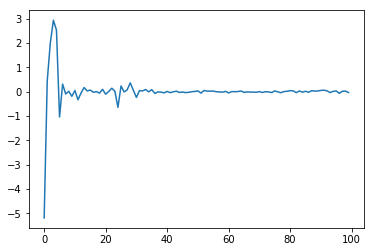

In [94]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# get the center of cluster 2, which is overrepresented
print(model_final.cluster_centers_[1])
# find maximum value and the index of it
max_val = np.amax(model_final.cluster_centers_[3])
print(max_val)
print(np.where(model_final.cluster_centers_[3] == max_val))
#plot
plt.plot(model_final.cluster_centers_[3])
# index is 0, print most weighted features of component 0
print_component(pca, 0)

[  4.65787310e+00  -2.78370097e+00   3.45480630e+00  -1.44837262e+00
   2.01998661e+00   2.41112523e+00  -4.48072077e-01  -2.88402636e-01
  -1.84552330e-01  -2.39194548e-01   2.55640314e-01   2.78676181e-01
   3.43242992e-01   3.28131063e-03  -1.09726040e-01   2.71365159e-01
  -9.73249987e-02  -3.74869121e-02  -5.96335643e-01  -1.28101359e-01
  -2.43187642e-01  -2.10907145e-01   3.36565412e-02  -1.10605339e-02
   5.71066014e-02   1.32361474e-01  -2.05560615e-02  -2.09011107e-02
  -4.50219194e-03  -1.75319963e-01  -1.80029784e-01   1.53043867e-02
   1.86729585e-01  -1.31780770e-02  -1.23062035e-01  -2.99138007e-01
  -1.07121957e-01   1.85930309e-01   9.64093500e-02   1.20434602e-01
  -2.93835366e-01   7.08691781e-02   1.08140193e-01   4.69076483e-02
   4.07174050e-02  -1.12947757e-01   8.35365342e-03  -2.14498885e-01
  -2.35218461e-02  -8.31327237e-02   8.78057510e-02  -5.56878787e-02
   2.29052584e-02   1.07124332e-01  -1.02270818e-01  -6.73318074e-03
   1.44345954e-01   8.84730432e-03

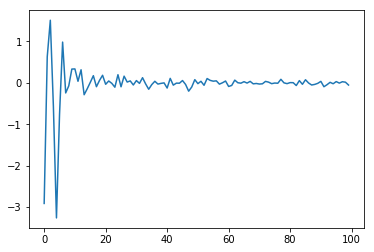

In [95]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster3 is underpresented in the customer dataset
# transform cluster center back, using 2 because here we start counting from 0
#scaler.inverse_transform(pca.inverse_transform(model_final.cluster_centers_[1]))
# get the center of cluster 3
print(model_final.cluster_centers_[2])
# find maximum value and the index of it
max_val = np.amax(model_final.cluster_centers_[1])
print(np.where(model_final.cluster_centers_[1] == max_val))
#plot
plt.plot(model_final.cluster_centers_[1])
# index is 1, print most weighted features of component 1
print_component(pca, 1)


### Discussion

The percentage of the customer in cluster 2 is much higher than the percentage of the general data in cluster 2. Therefore cluster 2 is overpresentated from the customer data. In cluster 2 are people with high income, representing the upper class and the build mostly there own house. They are the target people, they are popular with the company.

The percentage of the customer data in cluster 3 is much lower than the percentage of the general data in cluster 3. Therefore cluster 3 is underpresentated from the customer data. In cluster 2 are people with low income and they are sharing a lot of stuff like cars. The are unpopular with the company

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [46]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

mailout_train.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42962, 367)

0    42430
1      532
Name: RESPONSE, dtype: int64


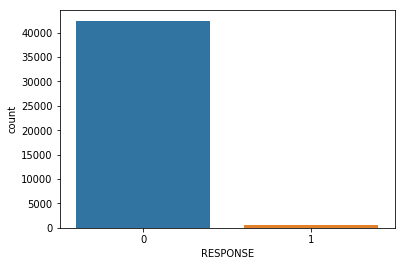

In [49]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

In [97]:
X_train = mailout_train.drop('RESPONSE', axis=1)
y_train = mailout_train['RESPONSE']
y_train.shape

(42962,)

In [98]:
X_train.shape

(42962, 366)

In [99]:
df_train  = clean_data(X_train, False)

df columns 18 and 19 converted to float
shape is:  (42962, 364)
df columns with more than 200000 missing values dropped
dropped columns are:  []
shape is:  (42962, 364)
df rows with 25 missing values dropped
shape is:  (42962, 364)
columns with correlation more than 0.7 are dropped
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42962, 254)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42962, 254)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42962, 254)
Imputing nan values with mode
shape after imputing the values (42962, 301)
Shape after normalising (42962, 301)


In [100]:
#split into test and train data
X_train, X_test, y_train, y_test = train_test_split(df_train, y_train, test_size=0.3, random_state=42)

In [101]:
# Create pipeline for classifier
pipeline = Pipeline([('classifier', RandomForestClassifier())])

paramter = [{'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 50, 100],
                 'classifier__max_features': [1, 2, 3]},
            {'classifier': [GradientBoostingRegressor(random_state=42)],
                 'classifier__n_estimators': [50, 100, 200],
                 'classifier__min_samples_split': [2, 3, 4]}]

In [102]:
#grid search
cv_obj = GridSearchCV(estimator=pipeline, param_grid=paramter, scoring = 'roc_auc')

#modelfit
cv_fit = cv_obj.fit(X_train, y_train)



In [103]:
# get the best classifier
choosen_classfier = cv_fit.best_estimator_
clf_predictions = choosen_classfier.predict(X_test)

print("ROC score on test data:", roc_auc_score(y_test, clf_predictions))

ROC score on test data: 0.760528389941


In [104]:
choosen_classfier

Pipeline(memory=None,
     steps=[('classifier', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False))])

In [105]:
# doing cross validation
stratfiedkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratfiedkfold.get_n_splits(X_train, y_train)

5

In [106]:
model = GradientBoostingRegressor(n_estimators=50, min_samples_split=3, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=stratfiedkfold, scoring='roc_auc', n_jobs=1)

In [107]:
score.mean()

0.7519956356693297

In [108]:
score

array([ 0.75184741,  0.7644229 ,  0.76978284,  0.74109447,  0.73283056])